In [1]:
import sys
sys.path.append("../src")
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F

import glob
import os
from datetime import datetime
import time
import math
from tqdm import tqdm

from itertools import repeat
from torch.nn.parameter import Parameter
import collections
import matplotlib
from torch_utils import *
from ExplicitModels import *
from visualization import *
# matplotlib.use('Agg')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.1306,), std=(0.3081,))])

mnist_dset_train = torchvision.datasets.MNIST('./data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(mnist_dset_train, batch_size=20, shuffle=True, num_workers=0)

mnist_dset_test = torchvision.datasets.MNIST('./data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(mnist_dset_test, batch_size=20, shuffle=False, num_workers=0)

In [4]:
def evaluatePC2(model, loader, device, apply_activation_inverse = True, activation_type = "sigmoid", printing = True):
    # Evaluate Predictive Coding Model on Classification Task
    correct=0
    phase = 'Train' if loader.dataset.train else 'Test'
    
    for x, y in loader:
        if apply_activation_inverse:
            x = activation_inverse(x.view(x.size(0),-1).T, activation_type).to(device)
        else:
            x = x.view(x.size(0),-1).T.to(device)

        y = y.to(device)
        
        neurons = model.fast_forward(x)

        pred = torch.argmax(neurons[-1][:10,:], dim=0).squeeze()  
        correct += (y == pred).sum().item()

    acc = correct/len(loader.dataset) 
    if printing:
        print(phase+' accuracy :\t', acc)   
    return acc

In [5]:
def mysoftmax(x, dim = 0):
    return F.softmax(x, dim)

def kWTA(inp_vector, k = 1):
    tmpx = torch.clone(inp_vector)
    topval = tmpx.topk(k, dim=0)[0][k - 1]
    topval = topval.repeat(tmpx.shape[0], 1)
    comp = (inp_vector>=topval)
    return comp*inp_vector

def Sparsify_kWTA(inp_vector, sparsity = 0.1):
    k = int(inp_vector.shape[0] * sparsity)
    if k == 0:
        k = 1
    tmpx = torch.clone(inp_vector)
    topval = tmpx.topk(k, dim=0)[0][k - 1]
    topval = topval.repeat(tmpx.shape[0], 1)
    comp = (inp_vector>=topval)
    return comp*inp_vector

activation = Sparsify_kWTA
# activation = torch.nn.LeakyReLU(0.0)
# activation = torch.sigmoid

architecture = [784, 500, 50]
nc = 10
lambda_ = 0.9999
epsilon = 0.01
neural_lr_start = 0.01
neural_lr_stop = 0.00
neural_lr_rule = "constant"
neural_lr_decay_multiplier = 0.005
neural_dynamic_iterations = 70

model = CorInfoMaxBiDirectional_wAutoGradV2(architecture, nc, lambda_, epsilon, activation, 
                                            optimizer_type = "sgd",
                                            optim_lr_ff = 0.01, optim_lr_fb = 0.0001, 
                                            use_stepLR = True, sgd_weight_decay = 0.001, 
                                            stepLR_step_size = 10*3000)

In [6]:
x, y = next(iter(train_loader))
x = x.view(x.size(0),-1).T
x, y = x.to(device), y.to(device)
y_one_hot = F.one_hot(y, 10).to(device).T
neurons = model.init_neurons(x.size(1))
# neurons = model.fast_forward(x)
# mode = "train"
# if mode == "train":
#     neurons[-1] = y.to(torch.float)


neurons = model.run_neural_dynamics( x, y_one_hot, neurons, neural_lr_start, neural_lr_stop, lr_rule = neural_lr_rule,
                                    lr_decay_multiplier = neural_lr_decay_multiplier, 
                                    neural_dynamic_iterations = neural_dynamic_iterations)

# neurons[-1]

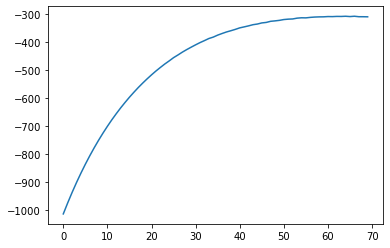

In [7]:
plt.plot(model.neural_dynamics_loss_list)

In [ ]:
model = CorInfoMaxBiDirectional_wAutoGradV2(architecture, nc, lambda_, epsilon, activation, 
                                            optimizer_type = "sgd",
                                            optim_lr_ff = 0.002, optim_lr_fb = 0.0001, 
                                            use_stepLR = True, sgd_weight_decay = 0.001, 
                                            stepLR_step_size = 10*3000)

trn_acc_list = []
tst_acc_list = []

n_epochs = 50

for epoch_ in range(n_epochs):
    if epoch_ > 12:
        neural_lr_start = 0.05
    if epoch_ > 17:
        neural_lr_start = 0.03
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        #x = activation_inverse(x.view(x.size(0),-1).T, "sigmoid")
        x = x.view(x.size(0),-1).T
        y_one_hot = F.one_hot(y, 10).to(device).T
        #y_one_hot = 0.94 * y_one_hot + 0.03 * torch.ones(*y_one_hot.shape, device = device)
        y_one_hot = 4*y_one_hot
        
        model.batch_step(  x, y_one_hot, neural_lr_start, neural_lr_stop, neural_lr_rule,
                           neural_lr_decay_multiplier, neural_dynamic_iterations,
                         )

    trn_acc = evaluatePC(model, train_loader, device, False, 
                         printing = False)
    tst_acc = evaluatePC(model, test_loader, device, False, 
                         printing = False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))

3000it [05:38,  8.87it/s]
1it [00:00,  7.92it/s]

Epoch : 1, Train Accuracy : 0.8594833333333334, Test Accuracy : 0.8644


3000it [05:39,  8.83it/s]
1it [00:00,  8.93it/s]

Epoch : 2, Train Accuracy : 0.8622666666666666, Test Accuracy : 0.8642


3000it [05:33,  8.99it/s]
1it [00:00,  8.32it/s]

Epoch : 3, Train Accuracy : 0.86275, Test Accuracy : 0.8648


3000it [05:33,  9.00it/s]
1it [00:00,  8.26it/s]

Epoch : 4, Train Accuracy : 0.8576, Test Accuracy : 0.8598


3000it [05:36,  8.91it/s]
1it [00:00,  8.43it/s]

Epoch : 5, Train Accuracy : 0.8607166666666667, Test Accuracy : 0.8604


3000it [05:36,  8.91it/s]
1it [00:00,  8.05it/s]

Epoch : 6, Train Accuracy : 0.86575, Test Accuracy : 0.8669


3000it [05:36,  8.91it/s]
1it [00:00,  8.18it/s]

Epoch : 7, Train Accuracy : 0.86025, Test Accuracy : 0.8612


3000it [05:37,  8.90it/s]
1it [00:00,  8.30it/s]

Epoch : 8, Train Accuracy : 0.85665, Test Accuracy : 0.8554


3000it [05:41,  8.78it/s]
1it [00:00,  8.14it/s]

Epoch : 9, Train Accuracy : 0.8380666666666666, Test Accuracy : 0.8339


3000it [05:42,  8.77it/s]
1it [00:00,  8.07it/s]

Epoch : 10, Train Accuracy : 0.812, Test Accuracy : 0.8116


3000it [05:43,  8.73it/s]
1it [00:00,  8.08it/s]

Epoch : 11, Train Accuracy : 0.8039166666666666, Test Accuracy : 0.8015


3000it [05:42,  8.76it/s]
1it [00:00,  8.50it/s]

Epoch : 12, Train Accuracy : 0.7645333333333333, Test Accuracy : 0.7647


3000it [05:45,  8.69it/s]
1it [00:00,  8.00it/s]

Epoch : 13, Train Accuracy : 0.6910166666666666, Test Accuracy : 0.6913


3000it [05:44,  8.70it/s]
1it [00:00,  8.37it/s]

Epoch : 14, Train Accuracy : 0.8491333333333333, Test Accuracy : 0.8473


3000it [05:44,  8.70it/s]
1it [00:00,  8.27it/s]

Epoch : 15, Train Accuracy : 0.8487333333333333, Test Accuracy : 0.8446


3000it [05:41,  8.78it/s]
1it [00:00,  8.50it/s]

Epoch : 16, Train Accuracy : 0.83995, Test Accuracy : 0.8387


3000it [05:42,  8.76it/s]
1it [00:00,  8.23it/s]

Epoch : 17, Train Accuracy : 0.82165, Test Accuracy : 0.8223


3000it [05:40,  8.80it/s]
1it [00:00,  8.23it/s]

Epoch : 18, Train Accuracy : 0.8151166666666667, Test Accuracy : 0.8119


3000it [05:42,  8.77it/s]
1it [00:00,  7.97it/s]

Epoch : 19, Train Accuracy : 0.7743166666666667, Test Accuracy : 0.7744


3000it [05:40,  8.81it/s]
1it [00:00,  7.90it/s]

Epoch : 20, Train Accuracy : 0.7355833333333334, Test Accuracy : 0.7376


3000it [05:38,  8.86it/s]
1it [00:00,  8.04it/s]

Epoch : 21, Train Accuracy : 0.7134666666666667, Test Accuracy : 0.7073


3000it [05:40,  8.81it/s]
1it [00:00,  8.23it/s]

Epoch : 22, Train Accuracy : 0.6883666666666667, Test Accuracy : 0.6855


3000it [05:43,  8.74it/s]
1it [00:00,  7.75it/s]

Epoch : 23, Train Accuracy : 0.6484333333333333, Test Accuracy : 0.6453


3000it [05:46,  8.66it/s]
1it [00:00,  8.14it/s]

Epoch : 24, Train Accuracy : 0.61325, Test Accuracy : 0.6064


3000it [05:45,  8.69it/s]
1it [00:00,  7.88it/s]

Epoch : 25, Train Accuracy : 0.5816, Test Accuracy : 0.58


3000it [05:45,  8.68it/s]
1it [00:00,  7.82it/s]

Epoch : 26, Train Accuracy : 0.5440833333333334, Test Accuracy : 0.5407


3000it [05:45,  8.68it/s]
1it [00:00,  8.10it/s]

Epoch : 27, Train Accuracy : 0.5188166666666667, Test Accuracy : 0.5183


3000it [05:43,  8.73it/s]
1it [00:00,  8.06it/s]

Epoch : 28, Train Accuracy : 0.49845, Test Accuracy : 0.4942


3000it [05:44,  8.72it/s]
1it [00:00,  7.73it/s]

Epoch : 29, Train Accuracy : 0.48206666666666664, Test Accuracy : 0.4793


3000it [05:42,  8.75it/s]
1it [00:00,  8.08it/s]

Epoch : 30, Train Accuracy : 0.46495, Test Accuracy : 0.4576


3000it [05:43,  8.74it/s]
1it [00:00,  7.81it/s]

Epoch : 31, Train Accuracy : 0.43816666666666665, Test Accuracy : 0.4356


3000it [05:42,  8.76it/s]
1it [00:00,  7.91it/s]

Epoch : 32, Train Accuracy : 0.42361666666666664, Test Accuracy : 0.4177


1830it [03:30,  8.75it/s]

In [ ]:
# def inverse_leaky_relu(x, negative_slope = 0.1):
#     out = torch.zeros(*x.shape)
#     out[x >]

In [ ]:
Wfb[1]['weight'] @ yy + Wfb[1]['bias']

In [ ]:
torch.clip(Wfb[1]['weight'] @ yy + Wfb[1]['bias'], 1e-3, 1-1e-3)

In [ ]:
model.Wfb[1]

In [ ]:
cc = 0
yy = torch.randn(10, 1).to(device)
yy[cc] = 4
Wfb = model.Wfb
out = torch.clip(Wfb[0]['weight'] @ activation_inverse(torch.clip(Wfb[1]['weight'] @ yy + Wfb[1]['bias'], 1e-3, 1-1e-3), 'sigmoid') + Wfb[0]['bias'], 1e-3, 1-1e-3).view(28 ,28)
out = torch2numpy(out)
plt.imshow(out)

In [ ]:
def accuracy_topk(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].flatten().float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
        
    result = [res_.item() for res_ in res]
    if len(result) == 1:
        result = result[0]
    return result

def evaluatePC_topk(model, loader, device, apply_activation_inverse = True, 
                    activation_type = "sigmoid", topk = [2], printing = True):
    # Evaluate Predictive Coding Model on Classification Task
    correct=0
    phase = 'Train' if loader.dataset.train else 'Test'
    
    for x, y in loader:
        if apply_activation_inverse:
            x = activation_inverse(x.view(x.size(0),-1).T, activation_type).to(device)
        else:
            x = x.view(x.size(0),-1).T.to(device)
        batch_size = x.size(1)
        y = y.to(device)
        
        neurons = model.fast_forward(x)

        #pred = torch.argmax(neurons[-1], dim=0).squeeze()  
        pred = neurons[-1]
        correct += accuracy_topk(pred.T, y, topk) * batch_size

    acc = correct/len(loader.dataset) 
    if printing:
        print(phase+' accuracy :\t', acc)   
    return acc

trn_acc = evaluatePC_topk(model, train_loader, device, False, 
                     printing = True, topk = [2])
tst_acc = evaluatePC_topk(model, test_loader, device, False, 
                     printing = True, topk = [2])

In [ ]:
for g in model.optimizer.param_groups:
    g['lr'] = g['lr']/100

In [ ]:


for epoch_ in range(n_epochs):
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        #x = activation_inverse(x.view(x.size(0),-1).T, "sigmoid")
        x = x.view(x.size(0),-1).T
        y_one_hot = F.one_hot(y, 10).to(device).T
        y_one_hot = 0.94 * y_one_hot + 0.03 * torch.ones(*y_one_hot.shape, device = device)
        
        model.batch_step(  x, y_one_hot, neural_lr_start, neural_lr_stop, neural_lr_rule,
                           neural_lr_decay_multiplier, neural_dynamic_iterations,
                         )

    trn_acc = evaluatePC(model, train_loader, device, False, 
                         printing = False)
    tst_acc = evaluatePC(model, test_loader, device, False, 
                         printing = False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))